<a href="https://colab.research.google.com/github/llumetta/480/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision – Spaceship Localization

**Problem:**

Your task is to build a convolutional neural network (CNN) that can detect a single spaceship in a noisy grayscale image. Every image will contain **exactly one spaceship**. Your model will take a 200×200 single-channel image as input and predict **five real-valued parameters** describing the spaceship's location, orientation, and size:

* **X, Y** position of the spaceship (center of the bounding box)
* **Yaw**, the orientation (heading) in radians
* **Width**, the size across the axis perpendicular to yaw
* **Height**, the size along the direction of yaw

---

**What You Must Do:**

We have provided the dataset generation, loss function, training loop, and evaluation script. Your **only responsibility** is to write a good CNN in the function:

```python
def gen_model(image_size=200):
    ...
```

This function must return a `tf.keras.Model` that:

* Accepts shape `(200, 200)`
* Outputs shape `(5,)` with real-valued predictions for `[x, y, yaw, width, height]`

---

**Deliverables:**

1. Your final version of `gen_model(...)` just paste that one function into colab.


---

**Starter Code Provided:**

* `make_data()` generates labeled training and test data
* `train_model(...)` trains your model using MSE loss
* `evaluate_model(...)` reports AP\@0.7 on 1000 test samples
* `show_examples()` visualizes sample images and ground truth labels

You are only modifying `gen_model(...)`.

---

### ⚡️ Google Colab Note:

If you're working in **Google Colab**, make sure to:

1. Click `Runtime` → `Change runtime type`
2. Set **Hardware Accelerator** to **GPU**
3. Click **Save**

This will significantly speed up your training.





### 📐 Geometry Module (`_rotation`, `_make_box_pts`, `_make_spaceship`)

#### Purpose:

These helper functions generate and transform the geometry of the spaceship and its bounding box.

#### Functions:

* **`_rotation(pts, theta)`**
  Rotates a set of 2D points `pts` by `theta` radians counterclockwise.

* **`_make_box_pts(x, y, yaw, w, h)`**
  Returns the four corner points of a rotated bounding box:

  * Centered at `(x, y)`
  * Rotated by `yaw`
  * With width `w` (across the yaw direction)
  * And height `h` (along the yaw direction)

* **`_make_spaceship(pos, yaw, scale, l2w, t2l)`**
  Generates a simple triangular spaceship shape based on:

  * `pos`: the center position (x, y)
  * `yaw`: orientation in radians
  * `scale`: overall size of the spaceship
  * `l2w`: length-to-width ratio
  * `t2l`: tip-to-length ratio

  Returns:

  * A set of 2D points forming the spaceship polygon
  * The label vector `[x, y, yaw, width, height]` representing its bounding box

---

### 🧪 Data Generation (`make_data`)

#### Purpose:

Creates synthetic training and test images, each containing exactly one spaceship with no noise.

#### Function:

* **`make_data(image_size=200)`**

  * Randomly places and rotates a spaceship within a 200×200 image.
  * Spaceship is drawn using its polygon perimeter with full contrast (value = 1.0).
  * No background noise or occlusions are added.

  Returns:

  * A 2D numpy array representing the grayscale image (shape: 200×200).
  * A label vector: `[x, y, yaw, width, height]`.

---

### 📏 IoU Scoring (`score_iou`)

#### Purpose:

Evaluates how closely a predicted bounding box matches the ground truth, using **Intersection over Union (IoU)**.

#### Function:

* **`score_iou(ypred, ytrue)`**

  * Converts both predictions and ground truth into polygon bounding boxes.
  * Uses the Shapely library to compute:

    ```
    IoU = Area of Intersection / Area of Union
    ```
  * Returns:

    * A float in `[0.0, 1.0]` if both boxes are valid
    * `0.0` if either input is invalid (contains NaNs)

---

### 🧾 Summary

| Component         | Role                                        |
| ----------------- | ------------------------------------------- |
| `_rotation`       | Applies 2D rotation matrix                  |
| `_make_box_pts`   | Computes corners of a rotated bounding box  |
| `_make_spaceship` | Defines a triangle-shaped spaceship         |
| `make_data`       | Generates labeled training images           |
| `score_iou`       | Quantifies bounding box prediction accuracy |

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon_perimeter
from shapely.geometry import Polygon
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, Reshape, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow import keras
from tqdm import tqdm


# === GEOMETRY ===
def _rotation(pts, theta):
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return pts @ r

def _make_box_pts(x, y, yaw, w, h):
    hx, hy = w / 2, h / 2
    box = np.array([[-hx, -hy], [-hx, hy], [hx, hy], [hx, -hy]])
    #box = _rotation(box, yaw)
    box += (x, y)
    return box

def _make_spaceship(pos, yaw, scale, l2w, t2l):
    dim_x, dim_y = scale, scale * l2w
    pts = np.array([
        (0, dim_y),
        (-dim_x / 2, 0),
        (0, dim_y * t2l),
        (dim_x / 2, 0),
    ])
    pts[:, 1] -= dim_y / 2
    #pts = _rotation(pts, yaw)
    pts += pos
    return pts, np.array([*pos, yaw, dim_x, dim_y])


# === DATA ===
def make_data(image_size=200, noise_level=0.0, salt_pepper_prob=0.0, no_lines=0):
    img = np.zeros((image_size, image_size))
    pos = np.random.randint(20, image_size - 20, size=2)
    yaw = 1

    # Vary the ship scale and aspect ratios
    scale = 25     # Base size
    l2w = 1   # Length-to-width
    t2l = 1        # Tip-to-length

    pts, label = _make_spaceship(pos, yaw, scale, l2w, t2l)

    rr, cc = polygon_perimeter(pts[:, 0], pts[:, 1])
    valid = (rr >= 0) & (rr < image_size) & (cc >= 0) & (cc < image_size)
    img[rr[valid], cc[valid]] = 1.0

    # Add Gaussian noise
    if noise_level > 0:
        img += np.random.normal(0.0, noise_level, img.shape)

    # Salt and pepper
    if salt_pepper_prob > 0:
        rand = np.random.rand(*img.shape)
        img[rand < (salt_pepper_prob / 2)] = 1.0
        img[rand > (1 - salt_pepper_prob / 2)] = 0.0

    # Line noise
    for _ in range(no_lines):
        x1, y1 = np.random.randint(0, image_size, 2)
        x2, y2 = np.random.randint(0, image_size, 2)
        num_points = max(abs(x2 - x1), abs(y2 - y1))
        xs = np.linspace(x1, x2, num_points).astype(np.int32)
        ys = np.linspace(y1, y2, num_points).astype(np.int32)
        xs = np.clip(xs, 0, image_size - 1)
        ys = np.clip(ys, 0, image_size - 1)
        img[ys, xs] = 1.0

    img = np.clip(img, 0.0, 1.0)

    return img.T, label





def score_iou(ypred, ytrue):
    if np.isnan(ypred).any() or np.isnan(ytrue).any():
        return 0.0
    p = Polygon(_make_box_pts(*ypred))
    t = Polygon(_make_box_pts(*ytrue))
    return p.intersection(t).area / p.union(t).area



### 📦 Batch Generator (`make_batch`)

#### Purpose:

Generates a mini-batch of synthetic training data consisting of clean spaceship images and corresponding labels.

#### Function Signature:

```python
def make_batch(batch_size, image_size=200)
```

#### Parameters:

* **`batch_size`** (`int`):
  The number of training samples (images and labels) to generate in this batch.

* **`image_size`** (`int`, default = `200`):
  The height and width of each square image (in pixels). The model expects 200×200 inputs.

#### Returns:

* **`imgs`** (`np.ndarray`):
  A 3D NumPy array of shape `(batch_size, image_size, image_size)` containing grayscale images with a visible spaceship.

* **`labels`** (`np.ndarray`):
  A 2D NumPy array of shape `(batch_size, 5)`, where each row is a label vector:
  `[x, y, yaw, width, height]`.



In [ ]:
def make_batch(batch_size, image_size=200):
    imgs, labels = zip(*[make_data(image_size) for _ in range(batch_size)])
    return np.stack(imgs), np.stack(labels)



---

### 🏋️ Model Training (`train_model`)

#### Purpose:

Trains a convolutional neural network to predict the bounding box and orientation of a spaceship in a clean 200×200 grayscale image.

#### Function Signature:

```python
def train_model(batch_size=64, epochs=10, image_size=200, model_path="model.h5")
```

#### Parameters:

* **`batch_size`** (`int`, default=`64`):
  Number of training samples per gradient update.

* **`epochs`** (`int`, default=`10`):
  Number of times the model sees the entire training set.

* **`image_size`** (`int`, default=`200`):
  Size of the input image (height and width in pixels).

* **`model_path`** (`str`, default=`"model.h5"`):
  Path to save the trained model after training.

#### Description:

This function performs the full training cycle:

1. Calls `gen_model(image_size)` to instantiate the student-designed model.
2. Compiles the model using **Adam** optimizer and **Mean Squared Error** loss (for regression).
3. Trains the model using a data generator that yields batches from `make_batch(...)`.
4. Saves the trained model in HDF5 format at the specified `model_path`.

The generator-based training setup allows for infinite synthetic data without manual dataset management.

#### Notes:

* The output layer should return 5 values: `[x, y, yaw, width, height]`.
* Training is done for `100` steps per epoch with randomized synthetic data.
* Ideal for use in Google Colab with GPU runtime for speed.

#### Returns:

None (but saves model to disk and prints a confirmation).

In [ ]:

# === TRAIN ===
def train_model(batch_size=64, epochs=10, image_size=200, model_path="model.h5"):
    model = gen_model(image_size)
    model.compile(optimizer=Adam(), loss=MeanSquaredError())
    model.summary()

    def generator():
        while True:
            yield make_batch(batch_size, image_size)

    model.fit(generator(), steps_per_epoch=100, epochs=epochs)
    model.save(model_path)
    print(f"✅ Model saved to {model_path}")


### ✅ Model Evaluation (`evaluate_model`)

#### Purpose:

Measures how well the trained model predicts bounding boxes and orientation using **Average Precision at IoU ≥ 0.7**.

#### Function Signature:

```python
def evaluate_model(model_path="model.h5", image_size=200)
```

#### Parameters:

* **`model_path`** (`str`, default=`"model.h5"`):
  Path to the saved trained model file (HDF5 format).

* **`image_size`** (`int`, default=`200`):
  Size of the input image used during training and evaluation.

#### Description:

1. Loads the trained model from disk.
2. Runs the model on **100 clean test images** generated by `make_data(...)`.
3. Computes the **IoU** between the predicted and true bounding boxes using `score_iou(...)`.
4. Computes the **Average Precision (AP)** at IoU threshold **0.7**:

   ```
   AP@0.7 = (# of IoUs > 0.7) / total
   ```
5. Prints the result to the console.

#### Output:

* Console output only. Prints something like:

  ```
  📈 AP@0.7 = 0.8900
  ```

#### Notes:

* This evaluation assumes **every image has a spaceship** (no false negative logic needed).
* Higher AP indicates better spatial accuracy of your bounding box predictions.

---

### 👀 Visualization (`show_examples`)

#### Purpose:

Displays a few synthetic spaceship images along with their ground-truth bounding boxes for visual inspection.

#### Function Signature:

```python
def show_examples(image_size=200)
```

#### Parameters:

* **`image_size`** (`int`, default=`200`):
  Size of each generated image.

#### Description:

1. Generates 3 clean spaceship images using `make_data(...)`.
2. Uses Matplotlib to render the image.
3. Overlays the true bounding box (in red) using `matplotlib.plot()` and `scatter()`.

#### Output:

* Pops up a Matplotlib window (or uses inline output in Colab).
* Each subplot shows:

  * A grayscale image
  * Red box showing spaceship boundary
  * Red dot for the center



In [ ]:
def evaluate_model(model_path="model.h5", image_size=200, distance_threshold=10.0):
    model = keras.models.load_model(model_path)
    distances = []

    for _ in tqdm(range(100)):
        img, label = make_data(image_size=image_size)
        pred = np.squeeze(model.predict(img[None]))

        # Extract x and y from prediction and label
        x_pred, y_pred = pred[0], pred[1]
        x_true, y_true = label[0], label[1]

        # Compute Euclidean distance between predicted and true center
        dist = np.sqrt((x_pred - x_true)**2 + (y_pred - y_true)**2)
        distances.append(dist)

    distances = np.array(distances)
    accuracy = (distances <= distance_threshold).mean()
    print(f"📏 Center Accuracy @ {distance_threshold} pixels = {accuracy:.4f}")


def show_examples(model, image_size=200):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        img, label = make_data(image_size=image_size)
        pred = np.squeeze(model.predict(img[None]))

        ax[i].imshow(img, cmap="gray")
        ax[i].set_title("Red = True, Blue = Pred")

        # Draw ground truth in red
        if not np.isnan(label).any():
            pts_true = _make_box_pts(*label)
            ax[i].plot(pts_true[:, 0], pts_true[:, 1], c="red")
            ax[i].scatter(label[0], label[1], c="red")

        # Draw prediction in blue
        if not np.isnan(pred).any():
            pts_pred = _make_box_pts(*pred)
            ax[i].plot(pts_pred[:, 0], pts_pred[:, 1], c="blue", linestyle='--')
            ax[i].scatter(pred[0], pred[1], c="blue", marker='x')

    plt.tight_layout()
    plt.show()



### 🧠 Model Architecture — `gen_model(...)`

> **💡 This is your only task.**

#### Purpose:

Design a convolutional neural network (CNN) that predicts the location, orientation, and size of a spaceship from a clean 200×200 grayscale image.

#### Function Signature:

```python
def gen_model(image_size=200)
```

#### Input:

* A single grayscale image of shape `(image_size, image_size)` — default is `200×200`.

#### Output:

* A tensor of shape `(5,)` representing the predicted real-valued parameters:
  `[x, y, yaw, width, height]`

---

### 📌 Your Assignment:

You must define the architecture inside `gen_model(...)` using Keras layers.

You are free to decide:

* How many convolutional layers to use
* How many filters per layer
* Where and when to apply:

  * Batch normalization
  * Max pooling
  * Flattening
  * Dropout (optional)
* The structure of the final Dense output

---

### ✅ Requirements:

* Your model must return a `Sequential` Keras model.
* The output shape must be `(5,)` with **no activation** (pure real-valued outputs).
* The rest of the training and evaluation pipeline has already been implemented for you.





In [1]:
# === MODEL ===
###This is you only task
def gen_model(image_size=200):
    model = Sequential()
    model.add(Reshape((image_size, image_size, 1), input_shape=(image_size, image_size)))
    #build your model here

    model.add(Flatten())
    model.add(Dense(5))
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       200,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,005 (781.27 KB)

 Trainable params: 200,005 (781.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 5068.7485
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4746.0566
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 4577.2671
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 4315.0903
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4237.8945
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 4014.1340
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 3828.4282
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 3736.0193
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 3564.9392
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 3375.8218


✅ Model saved to model.h5


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|          | 1/100 [00:00<00:19,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  5%|▌         | 5/100 [00:00<00:07, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 7/100 [00:00<00:06, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▉         | 9/100 [00:00<00:06, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█         | 11/100 [00:00<00:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|█▎        | 13/100 [00:00<00:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 15/100 [00:01<00:05, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 17/100 [00:01<00:05, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 19%|█▉        | 19/100 [00:01<00:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 21/100 [00:01<00:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 23/100 [00:01<00:04, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 25/100 [00:01<00:04, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 27/100 [00:01<00:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 29/100 [00:02<00:04, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 31%|███       | 31/100 [00:02<00:04, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 33/100 [00:02<00:04, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▌      | 35/100 [00:02<00:04, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 37/100 [00:02<00:04, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 39%|███▉      | 39/100 [00:02<00:04, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 41/100 [00:02<00:03, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 43%|████▎     | 43/100 [00:02<00:03, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 45/100 [00:03<00:03, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 47%|████▋     | 47/100 [00:03<00:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 49%|████▉     | 49/100 [00:03<00:03, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 51%|█████     | 51/100 [00:03<00:03, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 53%|█████▎    | 53/100 [00:03<00:03, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 55%|█████▌    | 55/100 [00:03<00:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 57%|█████▋    | 57/100 [00:03<00:02, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 59%|█████▉    | 59/100 [00:03<00:02, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████    | 61/100 [00:04<00:02, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 63%|██████▎   | 63/100 [00:04<00:02, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 65%|██████▌   | 65/100 [00:04<00:02, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 67%|██████▋   | 67/100 [00:04<00:02, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 69%|██████▉   | 69/100 [00:04<00:01, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 71%|███████   | 71/100 [00:04<00:01, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 73%|███████▎  | 73/100 [00:04<00:01, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 75%|███████▌  | 75/100 [00:05<00:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 77/100 [00:05<00:01, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 79%|███████▉  | 79/100 [00:05<00:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 81%|████████  | 81/100 [00:05<00:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 83%|████████▎ | 83/100 [00:05<00:01, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 85%|████████▌ | 85/100 [00:05<00:00, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 87%|████████▋ | 87/100 [00:05<00:00, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 89%|████████▉ | 89/100 [00:05<00:00, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 91%|█████████ | 91/100 [00:06<00:00, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 93/100 [00:06<00:00, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 95%|█████████▌| 95/100 [00:06<00:00, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 97%|█████████▋| 97/100 [00:06<00:00, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 99%|█████████▉| 99/100 [00:06<00:00, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 100/100 [00:06<00:00, 14.91it/s]

📏 Center Accuracy @ 10.0 pixels = 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


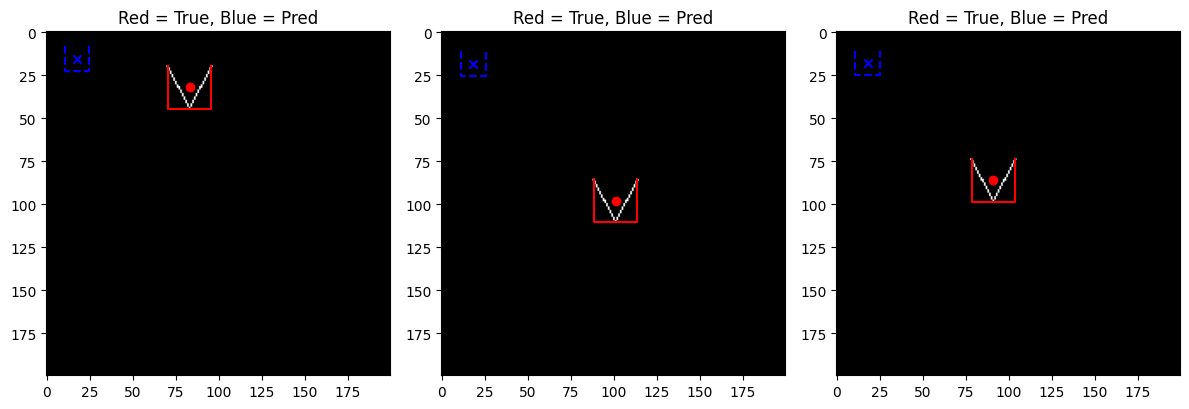

In [ ]:
# === EXECUTION BLOCK ===
train_model(epochs=10)

# Load the saved model
model = keras.models.load_model("model.h5")

# Evaluate on 100 test samples
evaluate_model()

# Show true vs. predicted bounding boxes
show_examples(model)



If you want to make it harder: you can add noise and lines all the way back up in,


def make_data(image_size=200, noise_level=0.0, salt_pepper_prob=0.0, no_lines=0):